Using GPU: /device:GPU:0
TensorFlow: 2.20.0
Train exists: True | Test exists: True
Copied -> Train apple=2000, banana=1917 | Test apple=500, banana=500
Found 3917 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Classes: ['apple', 'banana']
Numpy shapes: (3917, 96, 96, 3) (3917,) | (1000, 96, 96, 3) (1000,)

 Model Results (Apple vs Banana)
Model			Accuracy	Train Time (s)	Memory (KB)
KNN                     100.00%	    0.00	    164.69
SVM                      97.30%	    1.31	  78438.76
CNN                      96.20%	   13.86	   4251.29
Transfer Learning        99.90%	   29.69	   8408.61


,Algorithm,Accuracy,Training time (sec),Memory use (KB)
0,KNN,1.000,0.003708,164.691406
1,SVM,0.973,1.307260,78438.755859
2,CNN,0.962,13.855489,4251.292969
3,Transfer Learning,0.999,29.685717,8408.611328


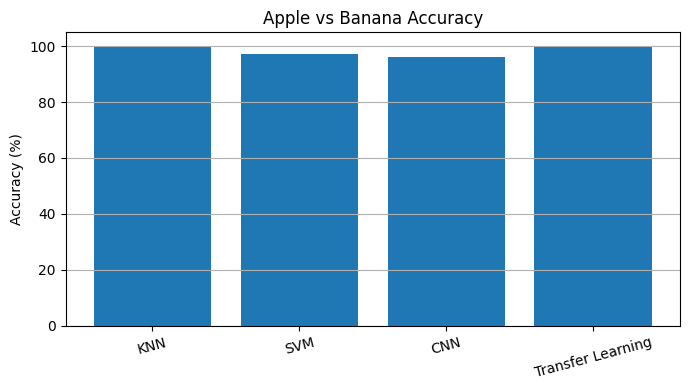

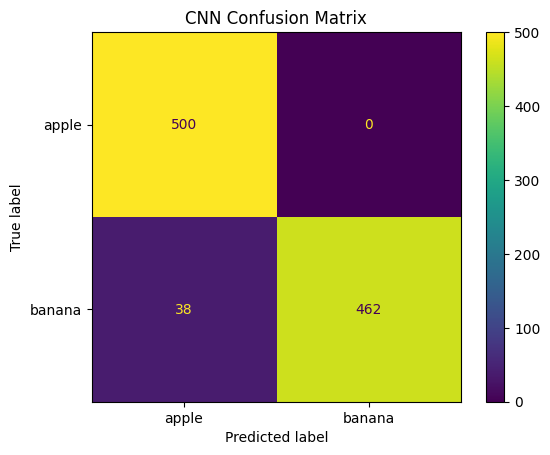

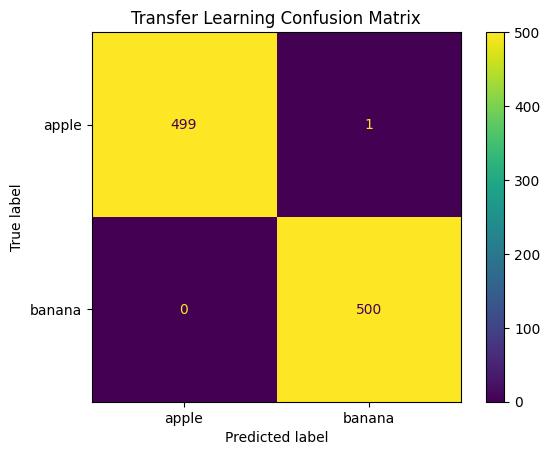


 Best by accuracy: KNN (Accuracy=100.00%)


In [1]:
# Setup
!pip -q install -U scikit-learn psutil matplotlib

import os, time, random, shutil, tracemalloc
from pathlib import Path
import numpy as np
import pandas as pd
import psutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU check
device_name = tf.test.gpu_device_name()
print("Using GPU:" if device_name else "No GPU found!", device_name)
print("TensorFlow:", tf.__version__)

# Download dataset
# Fruits-360 org hosts multiple repos; we use the 100x100 repo (Training/Test folders). [web:88]
DATA_DIR = Path("fruits-360-100x100")
if not DATA_DIR.exists():
    !git clone --depth 1 https://github.com/fruits-360/fruits-360-100x100.git

SRC_TRAIN = DATA_DIR / "Training"
SRC_TEST  = DATA_DIR / "Test"
print("Train exists:", SRC_TRAIN.exists(), "| Test exists:", SRC_TEST.exists())

# Build binary dataset: Apple vs Banana
BIN = Path("bin_data")
for split in ["Training", "Test"]:
    for cls in ["apple", "banana"]:
        (BIN / split / cls).mkdir(parents=True, exist_ok=True)

def is_apple(folder):  return folder.lower().startswith("apple")
def is_banana(folder): return folder.lower().startswith("banana")

def clear_bin():
    if BIN.exists():
        for p in BIN.rglob("*"):
            if p.is_file():
                p.unlink()

def copy_samples(src_root: Path, dst_split: Path, predicate, dst_class: str, max_images: int):
    all_files = []
    for d in src_root.iterdir():
        if d.is_dir() and predicate(d.name):
            all_files += list(d.glob("*.jpg")) + list(d.glob("*.jpeg")) + list(d.glob("*.png"))
    random.shuffle(all_files)
    all_files = all_files[:max_images]
    for i, f in enumerate(all_files):
        dst = dst_split / dst_class / f"{dst_class}_{i:06d}{f.suffix.lower()}"
        shutil.copyfile(f, dst)
    return len(all_files)

MAX_TRAIN_PER_CLASS = 2000
MAX_TEST_PER_CLASS  = 500

clear_bin()
n_train_a = copy_samples(SRC_TRAIN, BIN/"Training", is_apple,  "apple",  MAX_TRAIN_PER_CLASS)
n_train_b = copy_samples(SRC_TRAIN, BIN/"Training", is_banana, "banana", MAX_TRAIN_PER_CLASS)
n_test_a  = copy_samples(SRC_TEST,  BIN/"Test",     is_apple,  "apple",  MAX_TEST_PER_CLASS)
n_test_b  = copy_samples(SRC_TEST,  BIN/"Test",     is_banana, "banana", MAX_TEST_PER_CLASS)

print(f"Copied -> Train apple={n_train_a}, banana={n_train_b} | Test apple={n_test_a}, banana={n_test_b}")

# Load images
IMG_SIZE = (96, 96)
BATCH = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    BIN/"Training",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="binary",
    seed=SEED
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    BIN/"Test",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="binary",
    seed=SEED,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

def ds_to_numpy(ds):
    Xs, ys = [], []
    for x, y in ds:
        Xs.append(x.numpy())
        ys.append(y.numpy())
    X = np.concatenate(Xs, axis=0).astype("float32")
    y = np.concatenate(ys, axis=0).reshape(-1).astype("int32")
    return X, y

Xtr_img, ytr = ds_to_numpy(train_ds)
Xte_img, yte = ds_to_numpy(test_ds)
print("Numpy shapes:", Xtr_img.shape, ytr.shape, "|", Xte_img.shape, yte.shape)

# Helper: time + memory
results, times_s, memory_kb = {}, {}, {}
def track_fit(name, fit_fn):
    tracemalloc.start()
    t0 = time.time()
    fit_fn()
    t1 = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    times_s[name] = t1 - t0
    memory_kb[name] = peak / 1024.0


# 1) KNN (use MobileNetV2 features -> KNN)
feat_model = MobileNetV2(input_shape=IMG_SIZE+(3,), include_top=False, weights="imagenet", pooling="avg")
feat_model.trainable = False

def extract_features(imgs):
    imgs_pp = preprocess_input(imgs.copy())
    return feat_model.predict(imgs_pp, batch_size=64, verbose=0)

Xtr_feat = extract_features(Xtr_img)
Xte_feat = extract_features(Xte_img)

scaler = StandardScaler()
Xtr_f = scaler.fit_transform(Xtr_feat)
Xte_f = scaler.transform(Xte_feat)

knn = KNeighborsClassifier(n_neighbors=5)
track_fit("KNN", lambda: knn.fit(Xtr_f, ytr))
yp_knn = knn.predict(Xte_f)
results["KNN"] = accuracy_score(yte, yp_knn)


# 2) SVM (same features)
svm = SVC(kernel="rbf", C=10, gamma="scale")
track_fit("SVM", lambda: svm.fit(Xtr_f, ytr))
yp_svm = svm.predict(Xte_f)
results["SVM"] = accuracy_score(yte, yp_svm)


# 3) CNN
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
])

cnn = keras.Sequential([
    layers.Input(shape=IMG_SIZE+(3,)),
    data_aug,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid"),
])
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

EPOCHS_CNN = 5
track_fit("CNN", lambda: cnn.fit(train_ds, epochs=EPOCHS_CNN, verbose=0))
yp_cnn = (cnn.predict(test_ds, verbose=0).reshape(-1) > 0.5).astype("int32")
results["CNN"] = accuracy_score(yte, yp_cnn)


# 4) Transfer Learning (MobileNetV2 + head)
base = MobileNetV2(input_shape=IMG_SIZE+(3,), include_top=False, weights="imagenet", pooling="avg")
base.trainable = False

tl = keras.Sequential([
    layers.Input(shape=IMG_SIZE+(3,)),
    layers.Lambda(lambda x: preprocess_input(tf.cast(x, tf.float32))),
    base,
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])
tl.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

EPOCHS_TL = 3
track_fit("Transfer Learning", lambda: tl.fit(train_ds, epochs=EPOCHS_TL, verbose=0))
yp_tl = (tl.predict(test_ds, verbose=0).reshape(-1) > 0.5).astype("int32")
results["Transfer Learning"] = accuracy_score(yte, yp_tl)


# Report table
print("\n Model Results (Apple vs Banana)")
print("Model\t\t\tAccuracy\tTrain Time (s)\tMemory (KB)")
for name in results:
    print(f"{name:22s}{results[name]*100:8.2f}%\t{times_s[name]:8.2f}\t{memory_kb[name]:10.2f}")

df = pd.DataFrame({
    "Algorithm": list(results.keys()),
    "Accuracy": [results[k] for k in results.keys()],
    "Training time (sec)": [times_s[k] for k in results.keys()],
    "Memory use (KB)": [memory_kb[k] for k in results.keys()],
})
display(df)

# Simple plots
plt.figure(figsize=(7,4))
plt.bar(results.keys(), [v*100 for v in results.values()])
plt.ylabel("Accuracy (%)")
plt.title("Apple vs Banana Accuracy")
plt.grid(axis="y")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Confusion matrices (CNN + TL)
ConfusionMatrixDisplay(confusion_matrix(yte, yp_cnn), display_labels=class_names).plot()
plt.title("CNN Confusion Matrix")
plt.grid(False)
plt.show()

ConfusionMatrixDisplay(confusion_matrix(yte, yp_tl), display_labels=class_names).plot()
plt.title("Transfer Learning Confusion Matrix")
plt.grid(False)
plt.show()

# Best method (based on accuracy)
best = max(results, key=results.get)
print(f"\n Best by accuracy: {best} (Accuracy={results[best]*100:.2f}%)")
